<!--NAVIGATION-->
< [聚合与分组](03.08-Aggregation-and-Grouping.ipynb) | [目录](Index.ipynb) | [向量化的字符串操作](03.10-Working-With-Strings.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/03.09-Pivot-Tables.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Pivot Tables

# 數據透視表

> We have seen how the ``GroupBy`` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and ``GroupBy`` can sometimes cause confusion; it helps me to think of pivot tables as essentially a *multidimensional* version of ``GroupBy`` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

上一節我們學習了使用`GroupBy`來處理數據集之間的關係。 *數據透視表*也是一個類似的操作，我們經常會在電子表格或其他處理表格數據的程序中看到它。數據透視表將列狀的數據作為輸入，然後將它們組合到一個二維的表格中，通過這種組合結果提供數據在多個維度上的統計數據。數據透視表和`GroupBy`之間的區別經常會造成一些混亂；如果我們將數據透視表想像成一個*多維*版本的`GroupBy`聚合，會容易很多。也就是說，依然通過拆分-應用-組合的步驟，不過不是在一維的索引上進行，而是在二維的表格中進行。

## Motivating Pivot Tables

## 進入數據透視表

> For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)):

本小節的例子，我們將採用*泰坦尼克*的乘客數據，同樣來自Seaborn庫（參見[使用Seaborn進行可視化](04.14-Visualization-With-Seaborn.ipynb)）：

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Pivot() function
The pivot() function is used to reshape a given dataframe organised by given index/ column values. 

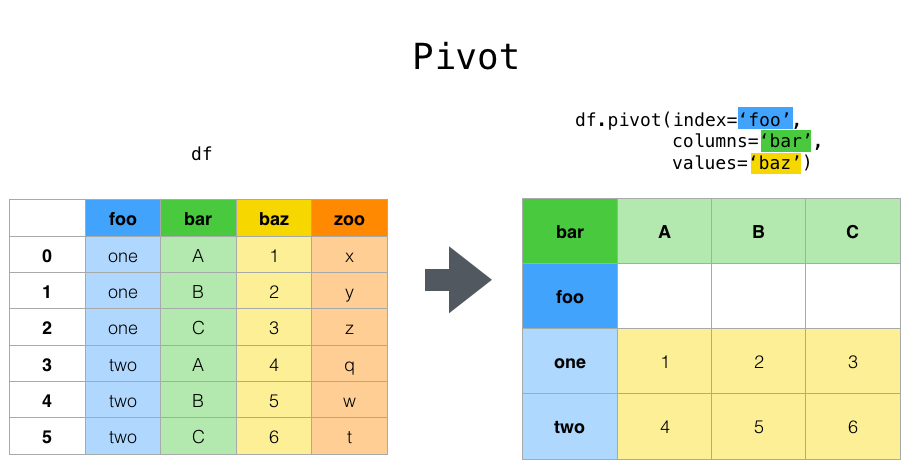

## Pivot Tables by Hand

## 手動生成數據透視表

> To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof.
If you have read the previous section, you might be tempted to apply a ``GroupBy`` operation–for example, let's look at survival rate by gender:

在深入分析數據之前，我們首先根據性別和存活狀態的相關性進行分組。根據上一節的內容，你可能會自然而然地使用`GroupBy`操作，例如，讓我們來獲得不同性別的存活率：

In [3]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


> This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

這個結果立刻能給我們一些數據的內在意義：普遍來說，四分之三的女性都存活了下來，而只有五分之一的男性存活了下來！

> This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

這很有用，但是我們可能希望進一步了解根據性別和艙位來統計存活率。如果我們用`GroupBy`的方法來描述這個過程的話，那麼很可能是這樣的：我們使用艙位和性別來*分組*，*選擇*存活狀態，*應用*平均值聚合操作，將結果的分組*組合*起來，然後*展開*成層次化的索引來展示隱藏的高維度。代碼如下：

In [4]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


> This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional ``GroupBy`` is common enough that Pandas includes a convenience routine, ``pivot_table``, which succinctly handles this type of multi-dimensional aggregation.

結果給了我們一個更好的關於性別和艙位是如何影響存活率的視角，但是代碼已經開始顯得有點混亂和難以閱讀了。當我們採用之前的知識來實現這個操作流的每一步的時候，代碼會變得越來越長，將會越來越難以使用和閱讀。這種二維的`GroupBy`對於在Pandas中進行普通分組統計時是足夠的，而透視表`pivot_table`，能簡潔的處理這種多維度的聚合操作。

## Pivot Table Syntax

## 數據透視表語法

> Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``s:

下面是我們使用`DataFrame`的`pivot_table`來實現這個操作的版本：

In [5]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


> This is eminently more readable than the ``groupby`` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both women and higher classes.
First-class women survived with near certainty (hi, Rose!), while only one in ten third-class men survived (sorry, Jack!).

上面的語法明顯比`groupby`版本要易讀多了，兩者的結果是一致的。結果告訴我們如果要搭乘20世紀初的跨大西洋遊輪的話，生存機率更加青睞於女性和高級艙位。頭等艙女性幾乎全部存活（Rose你好），而三等艙的男性只有十分之一的機率存活（Jack抱歉）。

### Multi-level pivot tables 多層透視表

> Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the ``pd.cut`` function:

就像`GroupBy`那樣，數據透視表的分組也可以指定多層次，還可以指定其他多個參數。例如，我們可能想要將年齡作為第三個維度。我們可以使用`pd.cut`將年齡進行分桶：

In [6]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

> We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

我們也可以將相同的方法應用到列上；下面我們在列上加上船票費用分組，使用`pd.qcut`將費用按比例自動分桶：

In [7]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

> The result is a four-dimensional aggregation with hierarchical indices (see [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb)), shown in a grid demonstrating the relationship between the values.

結果是一個四維的統計表，行和列都具有層次化的索引（參見[層次化索引](03.05-Hierarchical-Indexing.ipynb)），以表格的形式展示了對應四個不同維度的聚合數據。

## Example: Birthrate Data

## 例子：出生率數據

> As a more interesting example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, [this blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

下面來看一個更有趣的例子，使用由疾控中心提供的可自由獲取使用的美國的人口出生數據。（Andrew Gelman和他的團隊深入分析了這[數據](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)）：

In [10]:
# 如果你没有该数据集，可以用下面这条命令来下载它
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [13]:
births = pd.read_csv('input/births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


> We can start to understand this data a bit more by using a pivot table.
Let's add a decade column, and take a look at male and female births as a function of decade:

我們可以通過使用數據透視表來更好的理解這個數據集。讓我們加一列年代，來看一下每十年男孩和女孩的出生總數：

In [14]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


> We immediately see that male births outnumber female births in every decade.
To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year (see [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb) for a discussion of plotting with Matplotlib):

我們會立刻發現男孩的出生人數在每一個年代都超過了女孩。為了更加清晰地看到這個趨勢，我們可以使用Pandas內建的圖表工具來展示每年的男孩女孩的出生總數情況（參見[Matplotlib介紹](04.00-Introduction-To-Matplotlib.ipynb)）：

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set() 
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

> With a simple pivot table and ``plot()`` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.

使用一個簡單的數據透視表和內建的`plot()`方法，我們可以很容易的畫出區分性別的出生數趨勢圖。用肉眼觀測，可知在過去的50年中，男孩出生數大致比女孩出生數高出5%。

### Further data exploration 進一步數據分析

> Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point.
We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th).
One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation:

雖然下面的內容不一定與數據透視表有關，但是我們使用目前學習到的Pandas知識，就能從數據集中獲得更多有趣的特徵。首先我們應該對數據進行一定清洗，刪除由於錯誤輸入日期導致的離群值（例如6月31日）或者缺失值（例如6月99日）。一次性刪除這些離群數據的簡單辦法是通過一種叫sigma-clipping的穩健統計操作：

In [15]:
# 求出出生數的25%,50%和75%位置的值
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1] # mu為中位數
sig = 0.74 * (quartiles[2] - quartiles[0]) # sigma的值為75%位置與25%位置差的0.74倍

> This final line is a robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution (You can learn more about sigma-clipping operations in a book I coauthored with Željko Ivezić, Andrew J. Connolly, and Alexander Gray: ["Statistics, Data Mining, and Machine Learning in Astronomy"](http://press.princeton.edu/titles/10159.html) (Princeton University Press, 2014)).

最後一行代碼是樣本平均的穩健估計，0.74來源於標準正態分佈的四分位距（你可以在作者與Željko Ivezić、Andrew J. Connolly和Alexander Gray合著的書["Statistics, Data Mining, and Machine Learning in Astronomy"](http://press.princeton.edu/titles/10159.html)(Princeton University Press, 2014)中學習到更多有關sigma-clipping方法的知識）。

譯者註：對於標準正態分佈來說，均值為0，四分位距位於[-0.67448, 0, 0.67448]的位置，因此 IQR = Q3 - Q1 = 0.67448- (-0.67448) = 1.34896，得 $\frac{1}{1.34896}=0.74131$。

In [16]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

> Next we set the ``day`` column to integers; previously it had been a string because some columns in the dataset contained the value ``'null'``:

下面我們將日期`day`列設為整數類型；原本該列具有字符串類型因為數據集中該列存在值`'null'`：

In [17]:
# 將day列設置為整數類型
births['day'] = births['day'].astype(int)

> Finally, we can combine the day, month, and year to create a Date index (see [Working with Time Series](03.11-Working-with-Time-Series.ipynb)).
This allows us to quickly compute the weekday corresponding to each row:

最後，我們可以將年月日合併在一起成為一個時間序列（參見[在時間序列上操作](03.11-Working-with-Time-Series.ipynb)）。這令我們可以很方便的求出每一行日期是周幾：

In [18]:
births.index = pd.to_datetime(10000 * births.year + 100 * births.month + births.day, format='%Y%m%d')
births['dayofweek'] = births.index.dayofweek

/var/folders/9q/486czkcn7lv5v0hwbt71twdc0000gn/T/ipykernel_6916/832003187.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])


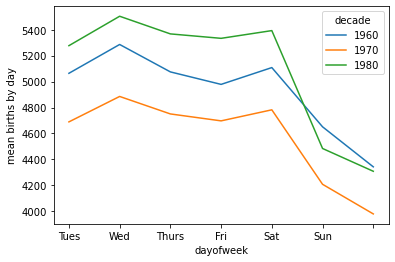

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

> Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

很明顯，出生數在休息日要比工作日少。還要注意到1990和2000年代數據缺失，原因是疾控中心的數據從1989年開始就只包含月份信息了。

> Another intersting view is to plot the mean number of births by the day of the *year*.
Let's first group the data by month and day separately:

另一個有趣的視角是分析每年每天的平均出生數。首先我們將月份和日期進行分組求平均值：

In [20]:
births_by_date = births.pivot_table('births', [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

> The result is a multi-index over months and days.
To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

結果當然，是一個月份和日期的多重索引數據集。然後需要簡單的繪製圖表，我們可以將上面的月份日期隨便放在一個閏年年份中形成完整的時間序列（閏年是為了保證2月29日也能包含在結果集中）：

In [21]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

/var/folders/9q/486czkcn7lv5v0hwbt71twdc0000gn/T/ipykernel_6916/4030178730.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_by_date.index = [pd.datetime(2012, month, day)


,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


> Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year.
From this, we can use the ``plot`` method to plot the data. It reveals some interesting trends:

我們只需要關注數據集中的月份和日期，上面的結果已經是一個時間序列上每天出生數的平均值。然後我們就可以使用`plot`方法來繪製圖表。結果會反映一些有趣的趨勢：

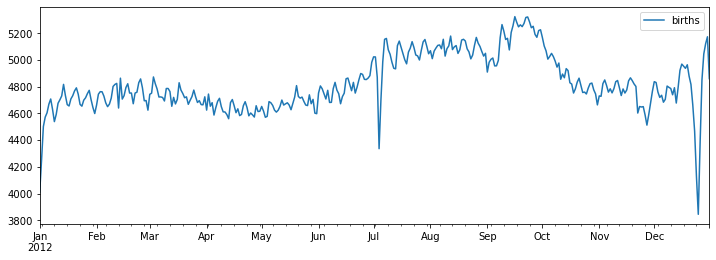

In [23]:
# 繪製每年每天的出生數平均值
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

> In particular, the striking feature of this graph is the dip in birthrate on US holidays (e.g., Independence Day, Labor Day, Thanksgiving, Christmas, New Year's Day) although this likely reflects trends in scheduled/induced births rather than some deep psychosomatic effect on natural births.
For more discussion on this trend, see the analysis and links in [Andrew Gelman's blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/) on the subject.
We'll return to this figure in [Example:-Effect-of-Holidays-on-US-Births](04.09-Text-and-Annotation.ipynb#Example:-Effect-of-Holidays-on-US-Births), where we will use Matplotlib's tools to annotate this plot.

上圖這個引人注目的結果表明出生率在美國假期的日期中都會下降（例如獨立日、勞動節、感恩節、聖誕節和新年），當然這並不代表節日對自然出生率在生物學上造成了影響，而是反映了醫學上對生育的額外處理的趨勢。對於有關這個趨勢更多的討論，可以參看[Andrew Gelman's blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)。我們會在[第四章第九節例子:節日對美國生育率的影響](04.09-Text-and-Annotation.ipynb#Example:-Effect-of-Holidays-on-US-Births)中繼續深入討論這個圖表，學習使用Matplotlib工具來標註這個圖表。

## Example

In [1]:
import pandas as pd
df = pd.read_csv('https://gist.githubusercontent.com/alexdebrie/b3f40efc3dd7664df5a20f5eee85e854/raw/ee3e6feccba2464cbbc2e185fb17961c53d2a7f5/stocks.csv')
df

,date,symbol,open,high,low,close,volume
0,2019-03-01,AMZN,1655.13,1674.26,1651.00,1671.73,4974877
1,2019-03-04,AMZN,1685.00,1709.43,1674.36,1696.17,6167358
2,2019-03-05,AMZN,1702.95,1707.80,1689.01,1692.43,3681522
3,2019-03-06,AMZN,1695.97,1697.75,1668.28,1668.95,3996001
4,2019-03-07,AMZN,1667.37,1669.75,1620.51,1625.95,4957017
5,2019-03-01,AAPL,174.28,175.15,172.89,174.97,25886167
6,2019-03-04,AAPL,175.69,177.75,173.97,175.85,27436203
7,2019-03-05,AAPL,175.94,176.00,174.54,175.53,19737419
8,2019-03-06,AAPL,174.67,175.49,173.94,174.52,20810384
9,2019-03-07,AAPL,173.87,174.44,172.02,172.50,24796374


In [2]:
df.pivot(index= 'symbol', columns= 'date', values='volume')

date,2019-03-01,2019-03-04,2019-03-05,2019-03-06,2019-03-07
symbol,,,,,
AAPL,25886167,27436203,19737419,20810384,24796374
AMZN,4974877,6167358,3681522,3996001,4957017
GOOG,1450316,1446047,1443174,1099289,1166559


In [3]:
df.pivot_table(values = 'volume', index = 'symbol')

,volume
symbol,
AAPL,23733309.4
AMZN,4755355.0
GOOG,1321077.0


In [4]:
df.pivot_table(values = 'volume', index = 'symbol', aggfunc = ['mean', 'max', 'min'])

,mean,max,min
,volume,volume,volume
symbol,,,
AAPL,23733309.4,27436203,19737419
AMZN,4755355.0,6167358,3681522
GOOG,1321077.0,1450316,1099289


### Example 1

In [5]:
# creating a dataframe
df = pd.DataFrame({'foo': ['one', 'one', 'one', 'two', 'two',
                           'two'],
                   'bar': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'baz': [1, 2, 3, 4, 5, 6],
                  'zoo': ['x', 'y', 'z', 'q', 'w', 't']})
df

,foo,bar,baz,zoo
0,one,A,1,x
1,one,B,2,y
2,one,C,3,z
3,two,A,4,q
4,two,B,5,w
5,two,C,6,t


In [6]:
# pivoting
df.pivot(index= 'foo', columns='bar', values='baz')

bar,A,B,C
foo,,,
one,1,2,3
two,4,5,6


In [7]:
# pivoting
df.pivot(index= 'foo', columns='bar', values=['baz','zoo'])

baz       zoo      
bar   A  B  C   A  B  C
foo                    
one   1  2  3   x  y  z
two   4  5  6   q  w  t

In [8]:
# creating a dataframe
df = pd.DataFrame({'foo': ['one', 'one', 'one', 'two', 'two',
                           'two'],
                   'bar': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'baz': [1, 2, 3, 4, 5, 6]})
df

,foo,bar,baz
0,one,A,1
1,one,B,2
2,one,C,3
3,two,A,4
4,two,B,5
5,two,C,6


In [9]:
# creating a new dataframe
d = {"zip_code": [12345, 56789, 101112, 131415],
"factory": [100, 400, 500, 600],
"warehouse": [200, 300, 400, 500],
"retail": [1, 2, 3, 4]
}

df = pd.DataFrame(d)
df

,zip_code,factory,warehouse,retail
0,12345,100,200,1
1,56789,400,300,2
2,101112,500,400,3
3,131415,600,500,4


In [10]:
# unpivoting all columns using the melt function
df = pd.melt(df, id_vars = "zip_code", var_name = "location_type", value_name = "distance")
df

,zip_code,location_type,distance
0,12345,factory,100
1,56789,factory,400
2,101112,factory,500
3,131415,factory,600
4,12345,warehouse,200
5,56789,warehouse,300
6,101112,warehouse,400
7,131415,warehouse,500
8,12345,retail,1
9,56789,retail,2


In [11]:
# pivoting
df = df.pivot(index = 'zip_code', columns  = 'location_type')
df = df['distance'].reset_index()
df.columns.name = None
df

,zip_code,factory,retail,warehouse
0,12345,100,1,200
1,56789,400,2,300
2,101112,500,3,400
3,131415,600,4,500


<!--NAVIGATION-->
< [聚合与分组](03.08-Aggregation-and-Grouping.ipynb) | [目录](Index.ipynb) | [向量化的字符串操作](03.10-Working-With-Strings.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/03.09-Pivot-Tables.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
